# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [2]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow
# !unzip dataset.zip

  Using cached https://files.pythonhosted.org/packages/31/9f/042db462417451e81035c3d43b722e88450c628a33dfda69777a801b0d40/scikit_learn-0.20.4-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/32/6b/0368cfa5e1d1ae169ab7dc78addda3fd5e6262e48d7373a9114bac7caff7/matplotlib-2.2.4-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1b/08/ff620ef5a6128ee6e7a505f5716f81fce7b71f3a69e99646ebe64e0b9984/Pillow-6.2.1-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d7/b1/3367ea1f372957f97a6752ec725b87886e12af1415216feec9067e31df70/numpy-1.16.5-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1d/f6/7c16d60aeb3694e5611976cb4f1eaf1c6b7f1e7c55771d691013405a02ea/scipy-1.2.2-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/da/d1/080d2bb13773803648281a49e3918f65b31b7beebf009887a529357fd44a/backports.functools_lru

In [3]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [4]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [5]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [6]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

X2,y2 = load_data("./dataset/IIIT-CFW/")
N2,H2,W2 = X2.shape[0:3]
C = 1 if opt['is_grayscale'] else X2.shape[3]
X2 = X2.reshape((N2,H2*W2*C))

X3,y3 = load_data("./dataset/Yale_face_database/")
N3,H3,W3 = X3.shape[0:3]
C = 1 if opt['is_grayscale'] else X3.shape[3]
X3 = X3.reshape((N3,H3*W3*C))

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


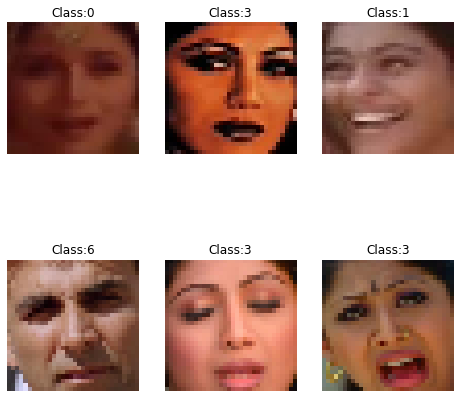

In [7]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [8]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))
X.shape

(400, 3072)

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [9]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    comps = pca.components_
    return X_k,comps,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [10]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [11]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [34]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [13]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [14]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [15]:
# Compute your features 
# eg.
# X_3D = get_kernel_lda(X,y,3)

                                    ###---Dataset-1 IMFDB---###
X_3D,comps,pca=get_pca(X,124)   ##### comps returns the eigen components 
X_3D2,comps2,pca2=get_pca(X2,309)
X_3D3,comps3,pca3=get_pca(X3,62)

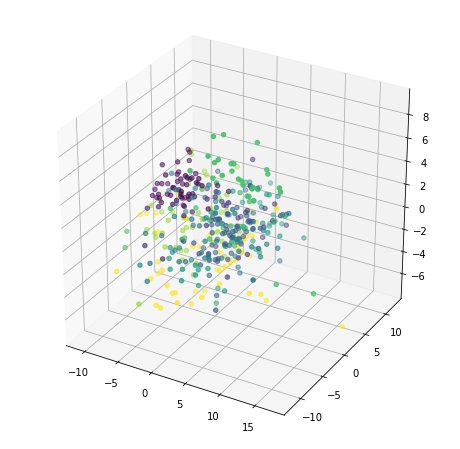

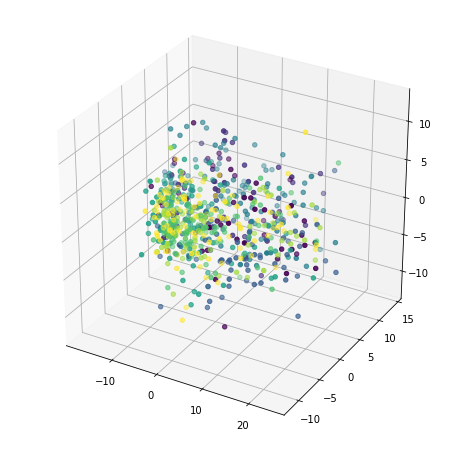

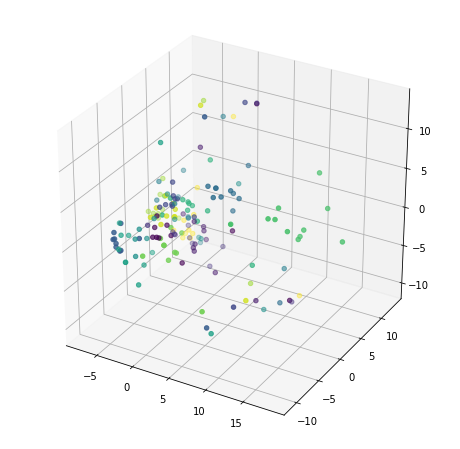

In [16]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D2[:,0],X_3D2[:,1],X_3D2[:,2],c=y2)
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D3[:,0],X_3D3[:,1],X_3D3[:,2],c=y3)
plt.show()

IMFDB DATASET:


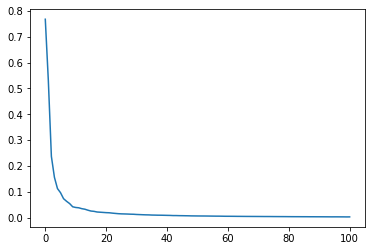

RANK: 399
Number of eigen faces req. to get 95%(Sastisfactory) of total eigen values in IMFDB: 124
IIIT-CFW DATASET:


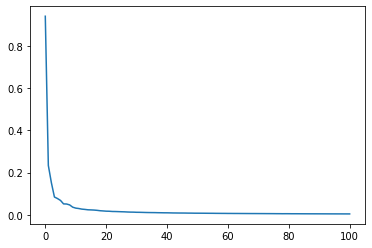

RANK: 671
Number of eigen faces req. to get 95%(Sastisfactory) of total eigen values in IIIT-CFW: 309
YALE DATASET:


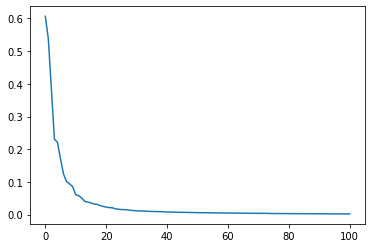

RANK: 160
Number of eigen faces req. to get 95%(Sastisfactory) of total eigen values in YALE: 62


In [17]:
# Plot the eigen value spectrum 

### Dataset-1: IMFDB
print("IMFDB DATASET:")
cov_train=np.cov(X,rowvar=False,bias=True)
eig=np.linalg.eigvals(cov_train)
eig=np.abs(eig)
x=np.linspace(0,100,101)
plt.plot(x,eig[0:101].T/np.linalg.norm(eig))
plt.show()
print("RANK:",np.linalg.matrix_rank(cov_train))
####for no. of eigen faces:
cumm=np.zeros((eig.shape))
# print(eig.shape,cumm.shape)
cumm[0]=eig[0]
for i in range(1,len(eig)):
  cumm[i]=cumm[i-1]+eig[i]
for i in range(1,len(cumm)):
  if(cumm[i]/cumm[-1]>=0.95):
    print("Number of eigen faces req. to get 95%(Sastisfactory) of total eigen values in IMFDB:",i+1)
    break
    
### Dataset-2: IIIT-CFW
print("IIIT-CFW DATASET:")
cov_train2=np.cov(X2,rowvar=False,bias=True)
eig2=np.linalg.eigvals(cov_train2)
eig2=np.abs(eig2)
x=np.linspace(0,100,101)
plt.plot(x,eig2[0:101].T/np.linalg.norm(eig2))
plt.show()
print("RANK:",np.linalg.matrix_rank(cov_train2))
####for no. of eigen faces:
cumm2=np.zeros((eig2.shape))
# print(eig.shape,cumm.shape)
cumm2[0]=eig2[0]
for i in range(1,len(eig2)):
  cumm2[i]=cumm2[i-1]+eig2[i]
for i in range(1,len(cumm2)):
  if(cumm2[i]/cumm2[-1]>=0.95):
    print("Number of eigen faces req. to get 95%(Sastisfactory) of total eigen values in IIIT-CFW:",i+1)
    break
    
### Dataset-3: YALE
print("YALE DATASET:")
cov_train3=np.cov(X3,rowvar=False,bias=True)
eig3=np.linalg.eigvals(cov_train3)
eig3=np.abs(eig3)
x=np.linspace(0,100,101)
plt.plot(x,eig3[0:101].T/np.linalg.norm(eig3))
plt.show()
print("RANK:",np.linalg.matrix_rank(cov_train3))
####for no. of eigen faces:
cumm3=np.zeros((eig3.shape))
# print(eig.shape,cumm.shape)
cumm3[0]=eig3[0]
for i in range(1,len(eig3)):
  cumm3[i]=cumm3[i-1]+eig3[i]
for i in range(1,len(cumm3)):
  if(cumm3[i]/cumm3[-1]>=0.95):
    print("Number of eigen faces req. to get 95%(Sastisfactory) of total eigen values in YALE:",i+1)
    break
    

1(c). Reconstruct  the  image  back for each case


In [18]:
def reconstruct_images(pca,X_3D):
#     """
#         Reconstruct the images back by just using the selected principal components. 
#         You have to write the code in this code block.
#         You can change the functions provided above (eg, get_pca, get_lda) for your use case.             
#         @params: 
#                 Input parameters
#         @return reconstructed_X => reconstructed image
        
#     """
    
#     pass
    reconstruct_X = pca.inverse_transform(X_3D)
    return reconstruct_X    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMFDB:


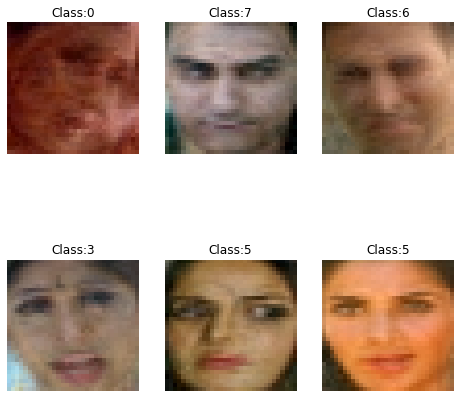

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction Error: 0.0385521030261274
IIIT-CFW:


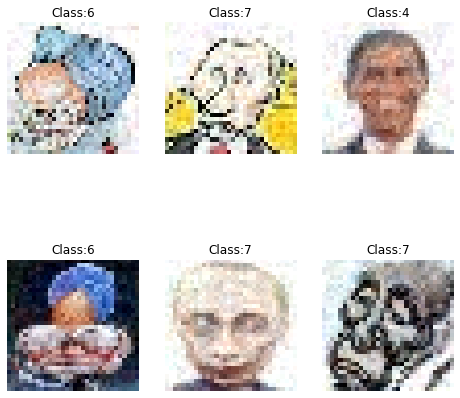

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction Error: 0.06816743171278378
YALE:


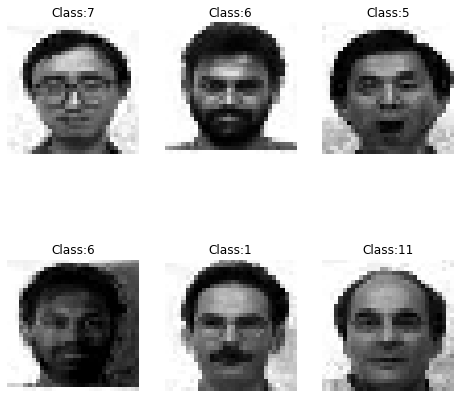

Reconstruction Error: 0.05379392906817366


In [19]:
# Display results 
# X_reconstruced = reconstruct_images()
import warnings
warnings.filterwarnings("ignore")
# print(comps.shape)
# re_X = np.dot(X_3D,comps)
# re_X.shape
re_X=reconstruct_images(pca,X_3D)
re_X=re_X.reshape(400,32,32,3)

re_X2=reconstruct_images(pca2,X_3D2)
re_X2=re_X2.reshape(672,32,32,3)

re_X3=reconstruct_images(pca3,X_3D3)
re_X3=re_X3.reshape(165,32,32,3)

# Display random images
print("IMFDB:")
ind = np.random.randint(0,y.shape[0],6)
disply_images(re_X[ind,...],y[ind],row=2,col=3)
re_X=re_X.reshape(400,3072)
print("Reconstruction Error:",np.sqrt(np.mean((X - re_X)**2)))
print("IIIT-CFW:")
ind2 = np.random.randint(0,y2.shape[0],6)
disply_images(re_X2[ind2,...],y2[ind2],row=2,col=3)
re_X2=re_X2.reshape(672,3072)
print("Reconstruction Error:",np.sqrt(np.mean((X2 - re_X2)**2)))
print("YALE:")
ind3 = np.random.randint(0,y3.shape[0],6)
disply_images(re_X3[ind3,...],y3[ind3],row=2,col=3)
# Show the reconstruction error
re_X3=re_X3.reshape(165,3072)
print("Reconstruction Error:",np.sqrt(np.mean((X3 - re_X3)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [20]:
# code goes here

# Reason: We got that the no. of eigenvectors for 95% of total eigen value sum is 124. So, the person with 
#         highest reconstruction error with "num_eig" no. of eig vectors is the most difficult to represent compactly.

                                    ###---Dataset-1 IMFDB---###
num_ids1=8
recon_error1=np.zeros(num_ids1)
for i in range(num_ids1):
  recon_error1[i]=np.sqrt(np.mean((X[y==i,:] - re_X[y==i,:])**2))
diff_id=np.argmax(recon_error1)
identity=list(imfdb_dict.keys())[diff_id]
print(identity," has the highest reconstruction error in IMFDB")

                                    ###---Dataset-2 IIIT-CFW---###
num_ids2=8
recon_error2=np.zeros(num_ids2)
for i in range(num_ids2):
  recon_error2[i]=np.sqrt(np.mean((X2[y2==i,:] - re_X2[y2==i,:])**2))
diff_id2=np.argmax(recon_error2)
identity2=list(cfw_dict.keys())[diff_id2]
print(identity2," has the highest reconstruction error in IIIT-CFW")

num_ids3=15
recon_error3=np.zeros(num_ids3)
for i in range(num_ids3):
  recon_error3[i]=np.sqrt(np.mean((X3[y3==i,:] - re_X3[y3==i,:])**2))
diff_id3=np.argmax(recon_error3)
# identity3=list(imfdb_dict.keys())[diff_id3]
print("Class-",diff_id3," has the highest reconstruction error in YALE")

SharukhKhan  has the highest reconstruction error in IMFDB
BarackObama  has the highest reconstruction error in IIIT-CFW
Class- 14  has the highest reconstruction error in YALE


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [35]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as conf_mat
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score as f1_s
from sklearn.preprocessing import MinMaxScaler,StandardScaler
class Classifier():
    def __init__(self):
#         super.__init__()
        self.hidden_layers=(150,50,25)
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.mlp.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        return conf_mat(y,pred)
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.mlp=MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=self.hidden_layers,max_iter=10000,alpha=1e-4)
        self.mlp.fit(X_train,y_train)
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        pred = self.classify(X_validate)
        # Create a confusion matrix
#         conf_mat=self.confusion_matrix(pred,y_validate)
        # Calculate Validation accuracy 
        acc_score = accuracy_score(y_validate,pred,normalize = True)
        # Calculate precision and recall 
        precision = precision_score(y_validate,pred,average = 'macro')
        recall = recall_score(y_validate,pred,average = 'macro')
        # Calculate F1-score
        f1_score = f1_s(y_validate,pred,average = 'macro')
        
        return acc_score,precision,recall,f1_score

In [36]:
# Create a train and validation split to train your classifier 

def get_table_vals(X,y,ind,dirpath,k1,k2,combine=False):
    accu=np.zeros(6)
    prec=np.zeros(6)
    rec=np.zeros(6)
    f1=np.zeros(6)
    i=0
    confuse=[]
    #### For pca:
    X_pca,comps,pca=get_pca(X,k1)
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = 0.2)
    sc = StandardScaler()
    X_train_pca = sc.fit_transform(X_train_pca)
    X_test_pca = sc.transform(X_test_pca)
    clf1 = Classifier()
    clf1.train(X_train_pca,y_train_pca)
    pred_pca = clf1.classify(X_test_pca)
    conf=clf1.confusion_matrix(pred_pca,y_test_pca)
    confuse.append(conf)
    acc_score,precision,recall,f1_score=clf1.validate(X_test_pca,y_test_pca)
#     print("Classification Accuracy in PCA in dataset-",ind,":",np.sum(pred_pca == y_test_pca)/len(y_test_pca))
    accu[i]=acc_score*100
    f1[i]=f1_score
    i+=1

    
    #### For k-pca:
    X_kpca,kpca=get_kernel_pca(X,k1)
    X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, test_size = 0.2)
    sc = StandardScaler()
    X_train_kpca = sc.fit_transform(X_train_kpca)
    X_test_kpca = sc.transform(X_test_kpca)
    clf2 = Classifier()
    clf2.train(X_train_kpca,y_train_kpca)
    pred_kpca = clf2.classify(X_test_kpca)
    conf2=clf2.confusion_matrix(pred_kpca,y_test_kpca)
    confuse.append(conf2)
    acc_score_kpca,precision_kpca,recall_kpca,f1_score_kpca=clf2.validate(X_test_kpca,y_test_kpca)
#     print("Classification Accuracy in K-PCA in dataset-",ind,":",np.sum(pred_kpca == y_test_kpca)/len(y_test_kpca))
    accu[i]=acc_score_kpca*100
    f1[i]=f1_score_kpca
    i+=1
    
    #### For LDA:
    X_lda = get_lda(X,y,k2)
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size = 0.2)
    # print(X_test_lda.shape)
    sc = StandardScaler()
    X_train_lda = sc.fit_transform(X_train_lda)
    X_test_lda = sc.transform(X_test_lda)
    clf3= Classifier()
    clf3.train(X_train_lda,y_train_lda)
    pred_lda = clf3.classify(X_test_lda)
    conf3=clf3.confusion_matrix(pred_lda,y_test_lda)
    confuse.append(conf3)
    acc_score_lda,precision_lda,recall_lda,f1_score_lda=clf3.validate(X_test_lda,y_test_lda)
#     print("Classification Accuracy in LDA in dataset-",ind,":",np.sum(pred_lda == y_test_lda)/len(y_test_lda))
    # print(acc_score_lda)
    accu[i]=acc_score_lda*100
    f1[i]=f1_score_lda
    i+=1
    
    #### For K-LDA:
    X_klda = get_kernel_lda(X,y,k2)
    X_train_klda, X_test_klda, y_train_klda, y_test_klda = train_test_split(X_klda, y, test_size = 0.2)
    # print(X_test_klda.shape)
    sc = StandardScaler()
    X_train_klda = sc.fit_transform(X_train_klda)
    X_test_klda = sc.transform(X_test_klda)
    clf4= Classifier()
    clf4.train(X_train_klda,y_train_klda)
    pred_klda = clf4.classify(X_test_klda)
    conf4=clf4.confusion_matrix(pred_klda,y_test_klda)
    confuse.append(conf4)
    acc_score_klda,precision_klda,recall_klda,f1_score_klda=clf4.validate(X_test_klda,y_test_klda)
#     print("Classification Accuracy in k-LDA in dataset-",ind,":",np.sum(pred_klda == y_test_klda)/len(y_test_klda))
    # print(acc_score_klda)
    accu[i]=acc_score_klda*100
    f1[i]=f1_score_klda
    i+=1
    if combine==False:
        #### For VGG-NET:
        X_vgg = get_vgg_features(dirpath)
        X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y, test_size = 0.2)
        # print(X_test_klda.shape)
        sc = StandardScaler()
        X_train_vgg = sc.fit_transform(X_train_vgg)
        X_test_vgg = sc.transform(X_test_vgg)
        clf5= Classifier()
        clf5.train(X_train_vgg,y_train_vgg)
        pred_vgg = clf5.classify(X_test_vgg)
        conf5=clf5.confusion_matrix(pred_vgg,y_test_vgg)
        confuse.append(conf5)
        acc_score_vgg,precision_vgg,recall_vgg,f1_score_vgg=clf5.validate(X_test_vgg,y_test_vgg)
    #     print("Classification Accuracy in VGG in dataset-",ind,":",np.sum(pred_vgg == y_test_vgg)/len(y_test_vgg))
        # print(acc_score_vgg)
        accu[i]=acc_score_vgg*100
        f1[i]=f1_score_vgg
        i+=1
        #### For RESNET:
        X_res = get_resnet_features(dirpath)
        X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y, test_size = 0.2)
        # print(X_test_klda.shape)
        sc = StandardScaler()
        X_train_res = sc.fit_transform(X_train_res)
        X_test_res = sc.transform(X_test_res)
        clf6= Classifier()
        clf6.train(X_train_res,y_train_res)
        pred_res = clf6.classify(X_test_res)
        conf5=clf5.confusion_matrix(pred_res,y_test_res)
        confuse.append(conf5)
        acc_score_res,precision_res,recall_res,f1_score_res=clf6.validate(X_test_res,y_test_res)
    #     print("Classification Accuracy in RESNET in dataset-",ind,":",np.sum(pred_res == y_test_res)/len(y_test_res))
        # print(acc_score_res)
        accu[i]=acc_score_res*100
        f1[i]=f1_score_res
    return accu,f1,confuse

In [37]:
import pandas as pd
from pandas import DataFrame
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
best_conf=[]
accu,f1,mat_conf=get_table_vals(X,y,1,"./dataset/IMFDB/",67,5)
ind=np.argmax(accu)
best_conf.append(mat_conf[ind])
print("Table for Dataset-1 IMFDB:")
df1=DataFrame({'Feature Space':["PCA+MLP","KPCA+MLP","LDA+MLP","KLDA+MLP","VGG+MLP","RESNET+MLP"],
               'Reduced-Dim-Space':[67,67,7,7,4096,2048],
               'Accuracy':list(accu),
               'Classification-Error':list(100*np.ones(6)-accu),
                'f1-score':list(f1)})
display(df1)

print("Table for Dataset-2 IIIT-CFW:")
X2,y2 = load_data("./dataset/IIIT-CFW/")
N2,H2,W2 = X2.shape[0:3]
C = 1 if opt['is_grayscale'] else X2.shape[3]
X2 = X2.reshape((N2,H2*W2*C))
accu2,f1_2,mat_conf_2=get_table_vals(X2,y2,2,"./dataset/IIIT-CFW/",309,5)
ind2=np.argmax(accu2)
best_conf.append(mat_conf_2[ind2])
df2=DataFrame({'Feature Space':["PCA+MLP","KPCA+MLP","LDA+MLP","KLDA+MLP","VGG+MLP","RESNET+MLP"],
               'Reduced-Dim-Space':[309,309,7,7,4096,2048],
               'Accuracy':list(accu2),
               'Classification-Error':list(100*np.ones(6)-accu2),
                'f1-score':list(f1_2)})
display(df2)

print("Table for Dataset-3 Yale:")
X3,y3 = load_data("./dataset/Yale_face_database/")
N3,H3,W3 = X3.shape[0:3]
C = 1 if opt['is_grayscale'] else X3.shape[3]
X3 = X3.reshape((N3,H3*W3*C))
accu3,f1_3,mat_conf_3=get_table_vals(X3,y3,3,"./dataset/Yale_face_database/",62,5)
ind3=np.argmax(accu3)
best_conf.append(mat_conf_3[ind3])
df3=DataFrame({'Feature Space':["PCA+MLP","KPCA+MLP","LDA+MLP","KLDA+MLP","VGG+MLP","RESNET+MLP"],
               'Reduced-Dim-Space':[62,62,14,14,4096,2048],
               'Accuracy':list(accu3),
               'Classification-Error':list(100*np.ones(6)-accu3),
                'f1-score':list(f1_3)})
display(df3)

Table for Dataset-1 IMFDB:


,Feature Space,Reduced-Dim-Space,Accuracy,Classification-Error,f1-score
0,PCA+MLP,67,71.25,28.75,0.718546
1,KPCA+MLP,67,78.75,21.25,0.772119
2,LDA+MLP,7,97.50,2.50,0.976496
3,KLDA+MLP,7,90.00,10.00,0.889093
4,VGG+MLP,4096,86.25,13.75,0.839177
5,RESNET+MLP,2048,95.00,5.00,0.949704


Table for Dataset-2 IIIT-CFW:
Dataset shape: (672, 32, 32, 3)


,Feature Space,Reduced-Dim-Space,Accuracy,Classification-Error,f1-score
0,PCA+MLP,309,27.407407,72.592593,0.238728
1,KPCA+MLP,309,34.814815,65.185185,0.370308
2,LDA+MLP,7,96.296296,3.703704,0.960840
3,KLDA+MLP,7,99.259259,0.740741,0.994315
4,VGG+MLP,4096,68.148148,31.851852,0.661961
5,RESNET+MLP,2048,98.518519,1.481481,0.980208


Table for Dataset-3 Yale:
Dataset shape: (165, 32, 32, 3)


,Feature Space,Reduced-Dim-Space,Accuracy,Classification-Error,f1-score
0,PCA+MLP,62,81.818182,18.181818,0.773016
1,KPCA+MLP,62,87.878788,12.121212,0.857778
2,LDA+MLP,14,100.000000,0.000000,1.000000
3,KLDA+MLP,14,100.000000,0.000000,1.000000
4,VGG+MLP,4096,60.606061,39.393939,0.596032
5,RESNET+MLP,2048,100.000000,0.000000,1.000000


In [40]:
# For each dataset print the confusion matrix for the best model 
def feature_model(i):
    if i==0:
        mod="PCA"
    elif i==1:
        mod="k-PCA"
    elif i==2:
        mod="LDA"
    elif i==3:
        mod="k-LDA"
    elif i==4:
        mod="VGG-NET"
    elif i==5:
        mod="RESNET"    
    return mod
mod1=feature_model(ind)
mod2=feature_model(ind2)
mod3=feature_model(ind3)
print("Confusion matrix of the best model in IMFDB Dataset:", mod1) 
print(best_conf[0])
print("Confusion matrix of the best model in IIIT-CFW Dataset:", mod2)
print(best_conf[1])
print("Confusion matrix of the best model in Yale Dataset:", mod3)
print(best_conf[2])

Confusion matrix of the best model in IMFDB Dataset: LDA
[[12  2  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0]
 [ 0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  9]]
Confusion matrix of the best model in IIIT-CFW Dataset: k-LDA
[[ 6  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0]
 [ 0  0  0  0 21  0  0  0]
 [ 0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 23  0]
 [ 0  0  0  0  0  1  0 21]]
Confusion matrix of the best model in Yale Dataset: RESNET
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

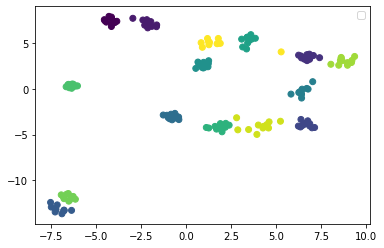

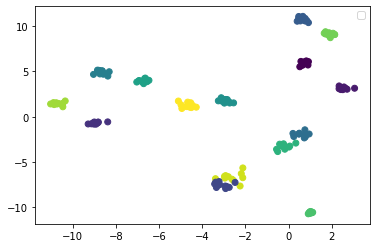

In [49]:
# Compute TSNE for different features and create a scatter plot
import warnings
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE

def scatter_tsne(X,y,k):
    # Compute
    X_TSNE = TSNE(n_components=k).fit_transform(X)
#     print(X_TSNE.shape)
    # Plot the representation in 2d/3d
    if k==3:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
    if k==2:
        plt.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y);
        plt.legend(handles=[1,2,3],labels = ['0','1','2']);
    plt.show()
###For IMFDB:
dirpath="./dataset/IMFDB/"
k=2
#### For pca:
X_pca,comps,pca=get_pca(X,67)
scatter_tsne(X_pca,y,k)
#### For k-pca:
X_kpca,kpca=get_kernel_pca(X,67)
scatter_tsne(X_kpca,y,k)
#### For LDA:
X_lda = get_lda(X,y,5)
scatter_tsne(X_lda,y,k)
#### For k-LDA:
X_klda = get_kernel_lda(X,y,5)
scatter_tsne(X_klda,y,k)
#### For VGG-NET:
X_vgg = get_vgg_features(dirpath)
scatter_tsne(X_vgg,y,k)
#### For RESNET:
X_res = get_resnet_features(dirpath)
scatter_tsne(X_res,y,k)

###For IIIT-cfw:
dirpath="./dataset/IIIT-CFW/"
k=2
# print(X2.shape)
#### For pca:
X1_pca,comps,pca=get_pca(X2,309)
# print(X1_pca.shape)
scatter_tsne(X1_pca,y2,k)
# #### For k-pca:
X_kpca,kpca=get_kernel_pca(X2,309)
scatter_tsne(X_kpca,y2,k)
#### For LDA:
X_lda = get_lda(X2,y2,5)
scatter_tsne(X_lda,y2,k)
#### For k-LDA:
X_klda = get_kernel_lda(X2,y2,5)
scatter_tsne(X_klda,y2,k)
#### For VGG-NET:
X_vgg = get_vgg_features(dirpath)
scatter_tsne(X_vgg,y2,k)
#### For RESNET:
X_res = get_resnet_features(dirpath)
scatter_tsne(X_res,y2,k)

###For Yale:
dirpath="./dataset/Yale_face_database/"
k=2
#### For pca:
X_pca,comps,pca=get_pca(X3,62)
scatter_tsne(X_pca,y3,k)
#### For k-pca:
X_kpca,kpca=get_kernel_pca(X3,62)
scatter_tsne(X_kpca,y3,k)
#### For LDA:
X_lda = get_lda(X3,y3,5)
scatter_tsne(X_lda,y3,k)
#### For k-LDA:
X_klda = get_kernel_lda(X3,y3,5)
scatter_tsne(X_klda,y3,k)
#### For VGG-NET:
X_vgg = get_vgg_features(dirpath)
scatter_tsne(X_vgg,y3,k)
#### For RESNET:
X_res = get_resnet_features(dirpath)
scatter_tsne(X_res,y3,k)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [50]:
from sklearn.neighbors import KNeighborsClassifier as KNN
class FaceVerification():
    def __init__(self,k):
            self.num_neigh = k
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        verification_results = (self.knn.predict(X) == class_id)
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.knn = KNN(n_neighbors = self.num_neigh)
        self.knn.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
        """
        pred=self.knn.predict(X_validate)
        Accuracy=np.sum(pred == y_validate)/len(y_validate)
        Accuracy=Accuracy*100
        # Calculate Validation accuracy 
        acc_score = accuracy_score(y_validate,pred,normalize = True)
        # Calculate precision and recall 
        precision = precision_score(y_validate,pred,average = 'macro')
        recall = recall_score(y_validate,pred,average = 'macro')
        # Calculate F1-score
        f1_score = f1_s(y_validate,pred,average = 'macro')
        # Calculate Error
        Error=100-Accuracy
        return acc_score,precision,recall,f1_score

In [57]:
# Create a train and validation split and show your results 
# X_pca=get_lda(X,y,5)
# # Create a train and validation split to train your classifier 
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = 0.2)
# # print(X_train.shape)
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train_pca)
# X_test = sc.transform(X_test_pca)
# clf = FaceVerification(k=7)
# clf.train(X_train_pca,y_train_pca)
# # pred = clf.classify(X_test_pca)
# acc_score,precision,recall,f1_score=clf.validate(X_test_pca,y_test_pca)
# # print("Classification Accuracy:",np.sum(pred == y_test_pca)/len(y_test_pca))
# print(acc_score)

def get_knntable_vals(X,y,ind,dirpath,k1,k2):
    accu=np.zeros(6)
    prec=np.zeros(6)
    rec=np.zeros(6)
    f1=np.zeros(6)
    i=0
#     confuse=[]
    #### For pca:
    X_pca,comps,pca=get_pca(X,k1)
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = 0.2)
    sc = StandardScaler()
    X_train_pca = sc.fit_transform(X_train_pca)
    X_test_pca = sc.transform(X_test_pca)
    face1 = FaceVerification(k=23)
    face1.train(X_train_pca,y_train_pca)
    acc_score,precision,recall,f1_score=face1.validate(X_test_pca,y_test_pca)
#     print("Classification Accuracy in PCA in dataset-",ind,":",np.sum(pred_pca == y_test_pca)/len(y_test_pca))
    accu[i]=acc_score*100
    f1[i]=f1_score
    i+=1

    
    #### For k-pca:
    X_kpca,kpca=get_kernel_pca(X,k1)
    X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, test_size = 0.2)
    sc = StandardScaler()
    X_train_kpca = sc.fit_transform(X_train_kpca)
    X_test_kpca = sc.transform(X_test_kpca)
    face2 = FaceVerification(k=23)
    face2.train(X_train_kpca,y_train_kpca)
    acc_score_kpca,precision_kpca,recall_kpca,f1_score_kpca=face2.validate(X_test_kpca,y_test_kpca)
#     print("Classification Accuracy in K-PCA in dataset-",ind,":",np.sum(pred_kpca == y_test_kpca)/len(y_test_kpca))
    accu[i]=acc_score_kpca*100
    f1[i]=f1_score_kpca
    i+=1
    
    #### For LDA:
    X_lda = get_lda(X,y,k2)
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size = 0.2)
    # print(X_test_lda.shape)
    sc = StandardScaler()
    X_train_lda = sc.fit_transform(X_train_lda)
    X_test_lda = sc.transform(X_test_lda)
    face3= FaceVerification(k=23)
    face3.train(X_train_lda,y_train_lda)
#     pred_lda = clf3.classify(X_test_lda)
#     conf3=clf3.confusion_matrix(pred_lda,y_test_lda)
#     confuse.append(conf3)
    acc_score_lda,precision_lda,recall_lda,f1_score_lda=face3.validate(X_test_lda,y_test_lda)
#     print("Classification Accuracy in LDA in dataset-",ind,":",np.sum(pred_lda == y_test_lda)/len(y_test_lda))
    # print(acc_score_lda)
    accu[i]=acc_score_lda*100
    f1[i]=f1_score_lda
    i+=1
    
    #### For K-LDA:
    X_klda = get_kernel_lda(X,y,k2)
    X_train_klda, X_test_klda, y_train_klda, y_test_klda = train_test_split(X_klda, y, test_size = 0.2)
    # print(X_test_klda.shape)
    sc = StandardScaler()
    X_train_klda = sc.fit_transform(X_train_klda)
    X_test_klda = sc.transform(X_test_klda)
    face4= FaceVerification(k=23)
    face4.train(X_train_klda,y_train_klda)
#     pred_klda = face4.classify(X_test_klda)
#     conf4=clf4.confusion_matrix(pred_klda,y_test_klda)
#     confuse.append(conf4)
    acc_score_klda,precision_klda,recall_klda,f1_score_klda=face4.validate(X_test_klda,y_test_klda)
#     print("Classification Accuracy in k-LDA in dataset-",ind,":",np.sum(pred_klda == y_test_klda)/len(y_test_klda))
    # print(acc_score_klda)
    accu[i]=acc_score_klda*100
    f1[i]=f1_score_klda
    i+=1
    #### For VGG-NET:
    X_vgg = get_vgg_features(dirpath)
    X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y, test_size = 0.2)
    # print(X_test_klda.shape)
    sc = StandardScaler()
    X_train_vgg = sc.fit_transform(X_train_vgg)
    X_test_vgg = sc.transform(X_test_vgg)
    face5= FaceVerification(k=23)
    face5.train(X_train_vgg,y_train_vgg)
#     pred_vgg = face5.classify(X_test_vgg)
#     conf5=clf5.confusion_matrix(pred_vgg,y_test_vgg)
#     confuse.append(conf5)
    acc_score_vgg,precision_vgg,recall_vgg,f1_score_vgg=face5.validate(X_test_vgg,y_test_vgg)
#     print("Classification Accuracy in VGG in dataset-",ind,":",np.sum(pred_vgg == y_test_vgg)/len(y_test_vgg))
    # print(acc_score_vgg)
    accu[i]=acc_score_vgg*100
    f1[i]=f1_score_vgg
    i+=1
    #### For RESNET:
    X_res = get_resnet_features(dirpath)
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y, test_size = 0.2)
    # print(X_test_klda.shape)
    sc = StandardScaler()
    X_train_res = sc.fit_transform(X_train_res)
    X_test_res = sc.transform(X_test_res)
    face6= FaceVerification(k=23)
    face6.train(X_train_res,y_train_res)
#     pred_res = clf6.classify(X_test_res)
#     conf5=clf5.confusion_matrix(pred_res,y_test_res)
#     confuse.append(conf5)
    acc_score_res,precision_res,recall_res,f1_score_res=face6.validate(X_test_res,y_test_res)
#     print("Classification Accuracy in RESNET in dataset-",ind,":",np.sum(pred_res == y_test_res)/len(y_test_res))
    # print(acc_score_res)
    accu[i]=acc_score_res*100
    f1[i]=f1_score_res
    return accu,f1

In [58]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
accu,f1=get_knntable_vals(X,y,1,"./dataset/IMFDB/",67,5)
# ind=np.argmax(accu)
# best_conf.append(mat_conf[ind])
print("Table for Dataset-1 IMFDB:")
df1=DataFrame({'Feature Space':["PCA+MLP","KPCA+MLP","LDA+MLP","KLDA+MLP","VGG+MLP","RESNET+MLP"],
               'Reduced-Dim-Space':[67,67,5,5,4096,2048],
               'Accuracy':list(accu),
               'Classification-Error':list(100*np.ones(6)-accu),
                'f1-score':list(f1)})
display(df1)
print("\n")
print("Table for Dataset-2 IIIT-CFW:")
accu2,f1_2=get_knntable_vals(X2,y2,2,"./dataset/IIIT-CFW/",309,5)
df2=DataFrame({'Feature Space':["PCA+MLP","KPCA+MLP","LDA+MLP","KLDA+MLP","VGG+MLP","RESNET+MLP"],
               'Reduced-Dim-Space':[309,309,5,5,4096,2048],
               'Accuracy':list(accu2),
               'Classification-Error':list(100*np.ones(6)-accu2),
                'f1-score':list(f1_2)})
display(df2)
print("\n")
print("Table for Dataset-3 Yale:")
accu3,f1_3=get_knntable_vals(X3,y3,3,"./dataset/Yale_face_database/",62,5)
# ind3=np.argmax(accu3)
# best_conf.append(mat_conf_3[ind3])
df3=DataFrame({'Feature Space':["PCA+MLP","KPCA+MLP","LDA+MLP","KLDA+MLP","VGG+MLP","RESNET+MLP"],
               'Reduced-Dim-Space':[62,62,5,5,4096,2048],
               'Accuracy':list(accu3),
               'Classification-Error':list(100*np.ones(6)-accu3),
                'f1-score':list(f1_3)})
display(df3)


Table for Dataset-1 IMFDB:


,Feature Space,Reduced-Dim-Space,Accuracy,Classification-Error,f1-score
0,PCA+MLP,67,20.00,80.00,0.088235
1,KPCA+MLP,67,17.50,82.50,0.132126
2,LDA+MLP,5,98.75,1.25,0.989048
3,KLDA+MLP,5,95.00,5.00,0.957816
4,VGG+MLP,4096,88.75,11.25,0.887451
5,RESNET+MLP,2048,92.50,7.50,0.924811




Table for Dataset-2 IIIT-CFW:


,Feature Space,Reduced-Dim-Space,Accuracy,Classification-Error,f1-score
0,PCA+MLP,309,20.000000,80.000000,0.075999
1,KPCA+MLP,309,17.037037,82.962963,0.061355
2,LDA+MLP,5,95.555556,4.444444,0.944678
3,KLDA+MLP,5,100.000000,0.000000,1.000000
4,VGG+MLP,4096,74.074074,25.925926,0.699631
5,RESNET+MLP,2048,96.296296,3.703704,0.963370




Table for Dataset-3 Yale:


,Feature Space,Reduced-Dim-Space,Accuracy,Classification-Error,f1-score
0,PCA+MLP,62,30.303030,69.696970,0.276998
1,KPCA+MLP,62,18.181818,81.818182,0.203210
2,LDA+MLP,5,63.636364,36.363636,0.658519
3,KLDA+MLP,5,33.333333,66.666667,0.400159
4,VGG+MLP,4096,42.424242,57.575758,0.383810
5,RESNET+MLP,2048,90.909091,9.090909,0.870748


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

(1072, 3072)
(1072,)
RANK: 399
The number of eigen faces required to get 90%(Sastisfactory) of total eigen values: 175


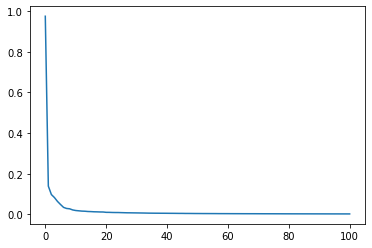

In [29]:
# Load data
## Cartoon vs Real using both IIIT-CFW + IMFDB Datasets
def load_new_data(dir_path):
    image_list = []
    y_list = []
    if "CFW" in dir_path:
        label_dict = new_cfw_dict
    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = new_imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    return image_list,y_list

new_imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 0,
     'SharukhKhan': 1,
     'ShilpaShetty': 0,
     'AmitabhBachan': 1,
     'KatrinaKaif': 0,
     'AkshayKumar': 1,
     'Amir': 1}

new_cfw_dict = {'Amitabhbachan': 1,
    'AamirKhan': 1,
    'DwayneJohnson': 1,
    'AishwaryaRai': 0,
    'BarackObama': 1,
    'NarendraModi': 1,
    'ManmohanSingh': 1,
    'VladimirPutin': 1}

Xnew1,ynew1=load_new_data("./dataset/IMFDB/")
Xnew2,ynew2=load_new_data("./dataset/IIIT-CFW/")
Xnew = np.vstack((Xnew1,Xnew2))
ynew = np.hstack((ynew1,ynew2))
Xnew=Xnew.reshape((Xnew.shape[0],Xnew.shape[1]*Xnew.shape[2]*Xnew.shape[3]))
print(Xnew.shape)
print(ynew.shape)
cov_train_new=np.cov(Xnew,rowvar=False,bias=True)
eig_new=np.linalg.eigvals(cov_train_new)
eig_new=np.abs(eig_new)
x=np.linspace(0,100,101)
plt.plot(x,eig_new[0:101].T/np.linalg.norm(eig_new))
print("RANK:",np.linalg.matrix_rank(cov_train))
####for no. of eigen faces:
cumm_new=np.zeros((eig_new.shape))
# print(eig.shape,cumm.shape)
cumm_new[0]=eig_new[0]
for i in range(1,len(eig)):
  cumm_new[i]=cumm_new[i-1]+eig_new[i]
for i in range(1,len(cumm_new)):
  if(cumm_new[i]/cumm_new[-1]>=0.9):
    print("The number of eigen faces required to get 90%(Sastisfactory) of total eigen values:",i+1)
    break
num_eigs_new=i+1

In [30]:
# Define your features
####From above experiments we can say that RESNET and LDA are pretty good feature representers.
#### So, LDA on RESNET features is a good featrure representation.

Xnew_res=np.vstack((get_resnet_features("./dataset/IMFDB"),get_resnet_features("./dataset/IIIT-CFW/")))
Xnew_lr,_,_ = get_pca(Xnew_res,150)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(Xnew_lr, ynew, test_size = 0.2)
sc = StandardScaler()
X_train_lr = sc.fit_transform(X_train_lr)
X_test_lr = sc.transform(X_test_lr)
clfnew= Classifier()
clfnew.train(X_train_lr,y_train_lr)
pred_lr = clfnew.classify(X_test_lr)
acc_score_lr,precision_lr,recall_lr,f1_score_lr=clfnew.validate(X_test_lr,y_test_lr)

#Comparing with other methods

accunew,f1new,mat_confnew=get_table_vals(Xnew,ynew,1,"./dataset/IMFDB/",150,5,combine=True)
print("Table for Dataset-1 IMFDB:")
accunew[4]=acc_score_lr*100
f1new[4]=f1_score_lr
df1=DataFrame({'Feature Space':["PCA","KPCA","LDA","KLDA","RESNET+PCA"],
               'Reduced-Dim-Space':[150,150,5,5,2048],
               'Accuracy':list(accunew[:5]),
               'Classification-Error':list(100*np.ones(5)-accunew[:5]),
                'f1-score':list(f1new[:5])})
display(df1)

Table for Dataset-1 IMFDB:


,Feature Space,Reduced-Dim-Space,Accuracy,Classification-Error,f1-score
0,PCA,150,86.976744,13.023256,0.830975
1,KPCA,150,88.372093,11.627907,0.840414
2,LDA,5,99.069767,0.930233,0.987317
3,KLDA,5,100.000000,0.000000,1.000000
4,RESNET+PCA,2048,97.209302,2.790698,0.966629


In [59]:
# Create your classifier     

############-----From the above Best Result (Accuracy and f1score): KLDA ---------------#####
Xnew_lr = get_kernel_lda(Xnew,ynew,5)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(Xnew_lr, ynew, test_size = 0.2)
# print(X_test_lda.shape)
sc = StandardScaler()
X_train_lr = sc.fit_transform(X_train_lr)
X_test_lr = sc.transform(X_test_lr)
clfnew= Classifier()
clfnew.train(X_train_lr,y_train_lr)
pred_lr = clfnew.classify(X_test_lr)
# confnew=clf3.confusion_matrix(pred_lda,y_test_lda)
# confuse.append(conf3)
# Validate your classifier
acc_score_lr,precision_lr,recall_lr,f1_score_lr=clfnew.validate(X_test_lr,y_test_lr)


Accuracy for k-LDA features: 99.53488372093024
5-fold cross -val mean accuracy: 99.6498028015776
Accuracies of individual folds [1.0, 0.9941860465116279, 1.0, 0.9941520467836257, 0.9941520467836257]


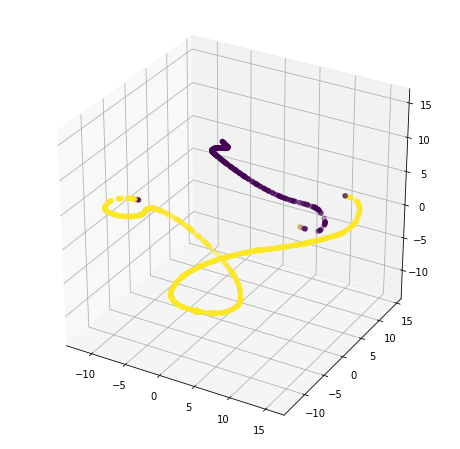

In [62]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
from sklearn.model_selection import KFold

print("Accuracy for k-LDA features:",acc_score_lr*100)
kf_accu=[]
kf = KFold(n_splits=5)
for train, test in kf.split(X_train_lr):
    X_train_kf, X_test_kf, y_train_kf, y_test_kf = X_train_lr[train], X_train_lr[test], y_train_lr[train], y_train_lr[test]
    acc_score_kf,precision_kf,recall_kf,f1_score_kf=clfnew.validate(X_test_kf,y_test_kf)
    kf_accu.append(acc_score_kf)
print("5-fold cross -val mean accuracy:", np.mean(np.array(kf_accu))*100)
print("Accuracies of individual folds",kf_accu)
def scatter_tsne(X,y,k):
    # Compute
    X_TSNE = TSNE(n_components=k).fit_transform(X)
#     print(X_TSNE.shape)
    # Plot the representation in 2d/3d
    if k==3:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
    if k==2:
        plt.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y);
        plt.legend(handles=[1,2,3],labels = ['0','1','2']);
    plt.show()
scatter_tsne(X_train_lr,y_train_lr,3)


Correctly classified image samples:


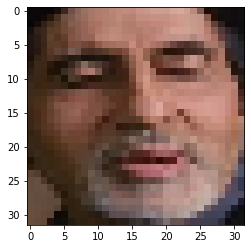

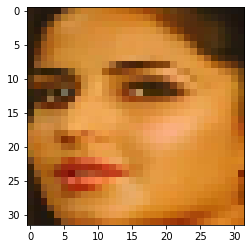

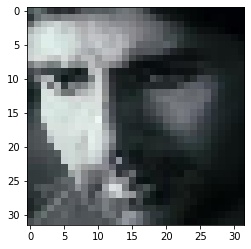

Incorrectly classified image samples:


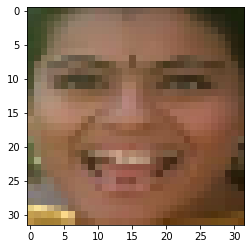

In [63]:
# Show quantitative results such as examples of correct prediction and wrong prediction
correct=0
incorrect=0
# fig, ax = plt.subplots(nrows=2, ncols=2)
# fig2, ax2 = plt.subplots(nrows=2, ncols=2)
corr=[]
incorr=[]
print("Correctly classified image samples:")
for i in range(len(pred_lr)):
    rand_ind=np.random.randint(1,len(pred_lr))
    if(pred_lr[rand_ind]==y_test_lr[rand_ind] and correct<=2):
        corr.append(Xnew[rand_ind,:].reshape(32,32,3))
        plt.imshow(corr[i])
        plt.show()
        correct+=1
    elif(pred_lr[i]!=y_test_lr[i] and incorrect<=4):
        incorr.append(Xnew[i,:].reshape(32,32,3))
        incorrect+=1
print("Incorrectly classified image samples:")
for i in range(len(incorr)):
    plt.imshow(incorr[i])
    plt.show()
    